# <font color="maroon">Chapter 5: Comparing MD and NMR Results</font>

<a href="https://githubtocolab.com/alsinmr/pyDR_tutorial/blob/main/ColabNotebooks/Ch5_MDvsNMR.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg"></a>

One of the biggest advantages of the *Detectors* approach is our ability to compare data from different sources. In this tutorial, we will look at comparing dynamics from NMR and MD data. However, we will also use detectors to compare, for example, the total motion in MD data to motion separated via reference frames ([ROMANCE](https://doi.org/10.1016/j.jmro.2022.100045)) and the total motion vs. detector analysis of the cross correlation of motion.

Note that if you're running this locally, you may need to manually [download](https://drive.google.com/file/d/1xgp5_BVeCh6Weu4tnsl1ToRZR49eM5hW/view?usp=share_link) the .xtc file and place it in
pyDR/examples/HETs15N.

## Setup and data downloads

In [0]:
# SETUP pyDR
import os
os.chdir('../..')

In [2]:
#Imports
import pyDR

### Downloading from Google Drive to Google Colab
In the tutorial, we will use files that are already stored as part of pyDR/examples. If you are working locally, you can just download outside of the Jupyter notebook and then tell pyDR later where the files are. However, in Google Colab, you need to get the files to the Colab server somehow. Here, we show how to download them from file IDs from Google Drive (these need to be viewable to anyone with the share link in your the share settings).

## Load and Process NMR
We'll do this in just a few lines. See the previous examples for processing NMR

In [4]:
#Empty pyDR project (specify directory if you want to save later)
proj=pyDR.Project()

# Download raw NMR data, store in project
nmr_link='https://drive.google.com/file/d/1w_0cR6ykjL7xvdxU2W90fRXvZ8XfLFc3/view?usp=share_link'
proj.append_data(pyDR.IO.readNMR(nmr_link))

# Specify the bond selection for the NMR data
# Note, we access select via the project. len(proj['NMR'])>1, this won't work, and we need to be more specific
proj['NMR'].select=pyDR.MolSelect(topo='pyDR/examples/HETs15N/backboneB.pdb') #Paths may need adjusted if running locally ()
proj['NMR'].select.select_bond('N',segids='B',resids=proj['NMR'].label)

#Setup detectors for NMR data (4 detectors, use S2 data)
proj['NMR'].detect.r_auto(4).inclS2()

#Fit the NMR data using the optimized detectors
proj['NMR'].fit()
print(proj)

Fitted 1 data objects
pyDIFRATE project with 2 data sets

titles:
r:NMR:1w_0cR6ykj
p5:NMR:1w_0cR6ykj



## Load MD and Process MD

###  Open MD trajectory, specify bonds

In [5]:
#Paths may need adjusted if running locally ()
sel=pyDR.MolSelect(topo='pyDR/examples/HETs15N/backboneB.pdb',  
                   traj_files='pyDR/examples/HETs15N/backboneB.xtc',
                   project=proj)

# Specify the bond select to analyze for MD
sel.select_bond('N',segids='B')

### Calculate the MD correlation functions
To speed up the tutorial, we take only every tenth point out of the MD trajectory (50 ps timesteps). Ideally, we would use all time points.

To calculate the rank-2 reorientational correlation functions, we use the md2data function on a selection object, which then exports the results to an MD data object
```
pyDR.md2data(sel)
```

In [6]:
sel.traj.step=10  #Take every tenth point for MD calculation (set to 1 for more accurate calculation)
pyDR.Defaults['ProgressBar']=False #Turns of the Progress bar (screws up webpage compilation)
pyDR.md2data(sel) #Calculate the MD correlation functions (automatically goes to proj)

r:MD:backboneB with 70 data points


Below, we view the sensitivies of the MD correlation function (only a selection of the 40000 sensitivities are shown)

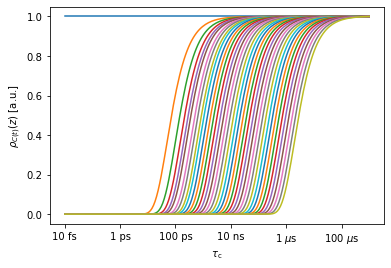

In [7]:
_=proj['MD']['raw'][0].sens.plot_rhoz()

### MD Preprocessing (fit with no_opt detectors)
When working with MD simulations, we produce a very large data set (here, the data object has 70x40000 data points, and if we hadn't skipped points in the trajectory, it would be 70x400000. We also have trajectories with 70x2000000 data points). We would rather not save that data, but would also like to avoid re-processing every time we need a change to the analysis.

The solution is to use a large (12-15) number of *unoptimized* detectors. Data from unoptimized detectors is difficult to interpret directly, but can be subsequently reprocessed to optimized detectors, and allows us to try different processing approaches without dealing with the large correlation functions with every attempt.

In [8]:
proj['MD'].detect.r_no_opt(12)  #Calculate 12 unoptimized detectors
proj['MD']['raw'].fit()  #Fit all raw MD data in the project (here, this is just the one data set)
print(proj)

Fitted 1 data objects
pyDIFRATE project with 4 data sets

titles:
r:NMR:1w_0cR6ykj
p5:NMR:1w_0cR6ykj
r:MD:backboneB
n12:MD:backboneB



### Detector Optimization
We can optimize the MD detectors for comparison to NMR data, or simply for analysis of the MD alone. The latter approach provides better information on the dynamics in the MD, but cannot be quantitatively compared to the NMR results.

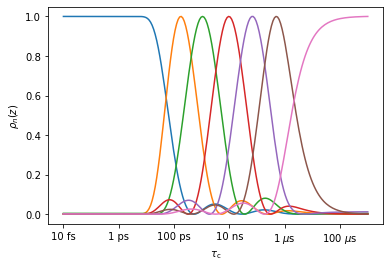

In [9]:
#Optimize 7 detectors, plot the resulting sensitivities
_=proj['MD']['no_opt'].detect.r_auto(7).plot_rhoz()

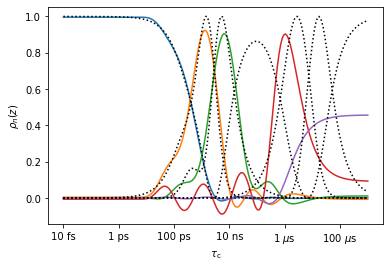

In [10]:
#Optimize detectors to match NMR data
target=proj['NMR']['proc'].sens.rhoz
target[0][99:]=0 #Zero out rho0 for better MD performance
#Optimize the MD detectors to target (NMR sensitivies).
#Increase n for better reproduction, but note that large n yield more noise
proj['MD']['no_opt'].detect.r_target(target,n=9)
#Plot the resulting detector, and compare to the original NMR detectors
ax=proj['MD']['no_opt'].detect.plot_rhoz(index=range(5))
_=proj['NMR']['proc'].sens.plot_rhoz(ax=ax,color='black',linestyle=':')

Above, we obtain reasonably good reproduction with $n=9$ for detectors 0-2 (ns/ps range). The latter 2 detectors ($\mu$s range) are poorly reproduced because the 2 $\mu$s trajectory is insufficient for reproducing microsecond dynamics.

### Process and plot MD data
We'll start by processing the MD data for evaluation without comparison to NMR.

In [11]:
#Optimize 7 detectors
proj['MD']['no_opt'].detect.r_auto(7)
#Fit the data with those 7 detectors
_=proj['MD']['no_opt'].fit()

Fitted 1 data objects


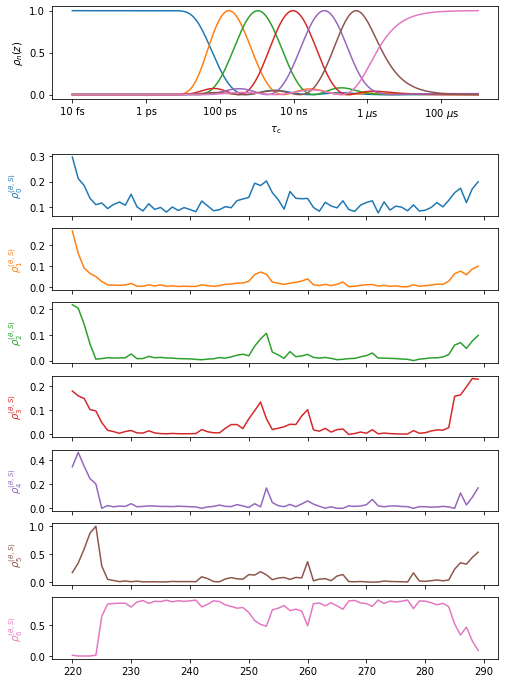

In [12]:
#Plot the results (be careful that we don't have open windows)
proj.close_fig('all')
proj['MD']['proc'].plot()
proj.plot_obj.fig.set_size_inches([8,12])

In [13]:
#Show the results for selected detectors in NGLviewer (may fail in Google Colab)
proj['MD']['proc'][0].nglview(rho_index=1,scaling=30)

NGLWidget(max_frame=400000)

In [14]:
#Show the results in ChimeraX (only works locally)
if 'google.colab' not in sys.modules:
#    #The path to chimeraX needs to be defined the first time this is run!!
#     pyDR.chimeraX.chimeraX_funs.set_chimera_path('path_to_executable')
    proj['MD']['proc'].chimera(scaling=30) #Adjust scaling to improve visibility for some detectors

The low amplitude "waves" in the detector sensitivies can be removed if desired. The waves may capture some motion significantly faster or slower than the detector's mean position, and so can be inconvenient for data analysis. However, their removal can in principle distort the data, although we have never observed any significant distortion from their removal.

Optimized 1 data objects


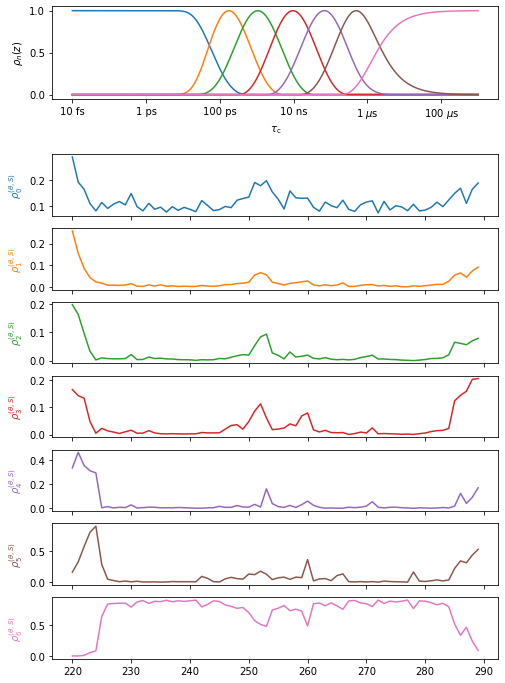

In [15]:
# Optimize the MD fit and cleanup the sensitivity "waves"
proj['MD']['proc'].opt2dist(rhoz_cleanup=True)
# Plot the new fit
proj.close_fig('all')
proj['MD']['opt_fit'].plot()
proj.plot_obj.fig.set_size_inches([8,12])

## Compare NMR results to MD results

### Optimize MD detectors to match NMR detectors

In [16]:
target=proj['NMR']['proc'].sens.rhoz
target[0][99:]=0 #Zero out rho0 for better MD performance
proj['MD']['no_opt'].detect.r_target(target,n=9)

#Fit the MD data to detectors optimized for comparison to NMR
_=proj['MD']['no_opt'].fit()

Fitted 1 data objects


### Plot the comparison between NMR and MD
pyDR compares detector sensitivies between data sets to decide which detector windows are most comparable. Furthermore, it determines based on the selection object or the data labels what positions should be plotted on top of each other. Therefore, we do not need to do anything but specify what should be plotted.

Note that the project manages the plotting. It will always try to plot into the previous plot, unless we set the current plot.
```
proj.current_plot=2 #Generate a new plot. Counting starts at 1, which is the default
proj.close_fig('all') #Close figure by number, or specify 'all', to delete all plots (then uses plot 1)
```
This behavior is usually convenient. However, in Jupyter notebooks, if one already has an open plot in a previous cell, it will not show up in a new cell by default (thus why we start plotting by closing all plots). Furthermore, if data with very different sensitivies are plotted into the same plot object, the second data set may not plot at all.

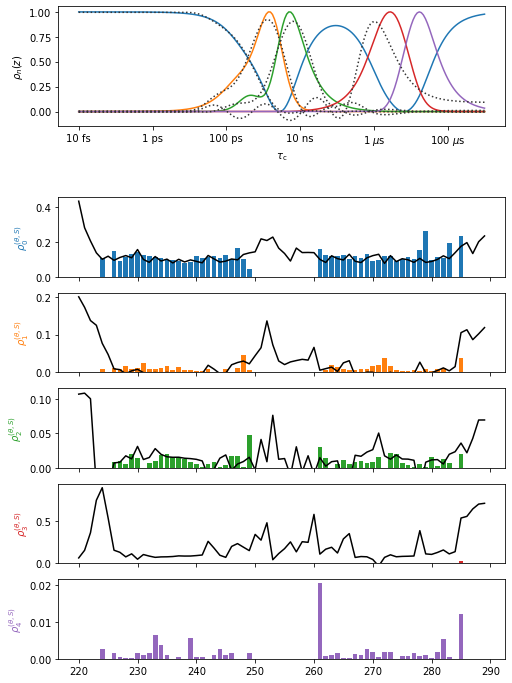

In [17]:
proj.close_fig('all')
#Plot the NMR data
proj['NMR']['proc'].plot(style='bar')
#Plot the MD data, that was matched to the NMR (p9 refers to the n=9 detectors)
_=proj['MD']['p9.'].plot()

proj.plot_obj.fig.set_size_inches([8,12])
for a in proj.plot_obj.ax:a.set_ylim([0,a.get_ylim()[1]])

No MD data is plotted for the last detector, since the detector sensitivies were very different. Note that typically MD-derived microsecond motion is difficult to reproduce. Also, note that this data set is better reproduced with longer, optimized MD trajectories.